# Analyse de la performance des modèles entrainés

Différents angles à analyser :
- Existe des classes présentes en nombre mais tout de même mal prédites ?
- A quoi resemble les libellés des classes mal prédites ? Ressemblent-ils à d'autres ? 
- Quelles sont les classes qui sont prédites avec les plus fortes/faibles proba ?
- Est-ce que les erreurs sont faites seulement lorsque la probab associée est faible ou non ?

In [4]:
import sys

import mlflow
import pandas as pd
import yaml

from constants import TEXT_FEATURE, Y
from fasttext_classifier.fasttext_evaluator import FastTextEvaluator
from fasttext_classifier.fasttext_preprocessor import FastTextPreprocessor
from fasttext_classifier.fasttext_wrapper import FastTextWrapper
from utils import get_root_path

In [5]:
preprocessor = FastTextPreprocessor()

In [6]:
df = pd.read_parquet("../data/extraction_sirene_20220602.parquet", engine="pyarrow")

config_path = "config/config_fasttext4.yaml"
with open(get_root_path() / config_path, "r") as stream:
    config = yaml.safe_load(stream)
params = config["params"]
categorical_features = config["categorical_features"]

In [7]:
df_train, df_test, df_gu = preprocessor.preprocess(
    df=df,
    y=Y,
    text_feature=TEXT_FEATURE,
    categorical_features=categorical_features,
)

Pour importer un seul modèle spécifique, il suffit de run les commandes suivantes : 

- export PYTHONPATH="$PWD:$PYTHONPATH"

- export MC_HOST_minio=https://$AWS_ACCESS_KEY_ID:$AWS_SECRET_ACCESS_KEY:$AWS_SESSION_TOKEN@$AWS_S3_ENDPOINT

- mc cp -r minio/projet-ape/mlflow-artifacts/1/33e88b4c4a084622abfb102391e73af0/artifacts/default/artifacts/ models/

In [8]:
import fasttext
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

In [9]:
model = fasttext.load_model("../models/default.bin")
evaluator = FastTextEvaluator(model)

In [10]:
res_gu = evaluator.get_aggregated_APE_dict(df_gu, Y, TEXT_FEATURE, ["AUTO", "NAT_SICORE"])
#res_test = evaluator.get_aggregated_APE_dict(df_test, Y, TEXT_FEATURE, ["AUTO", "NAT_SICORE"])

100%|██████████| 4/4 [00:00<00:00, 656.36it/s]


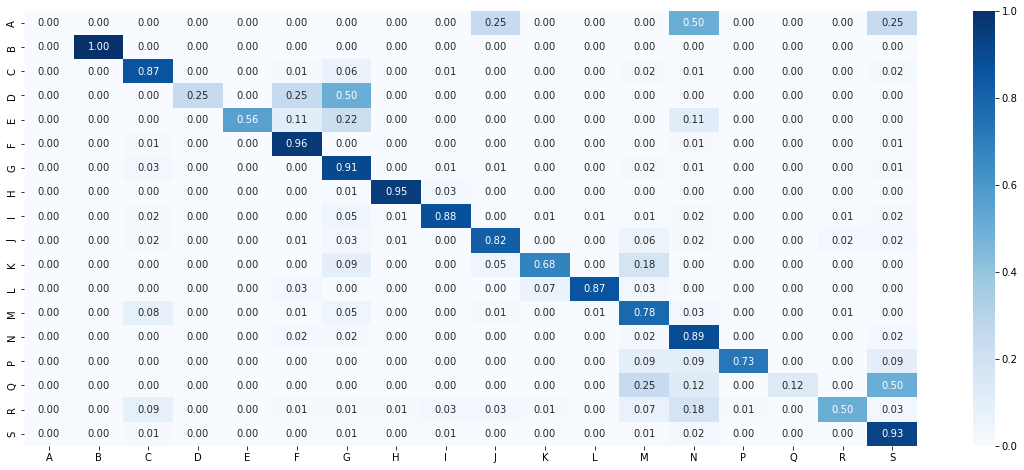

In [11]:
fig = evaluator.plot_matrix(res_gu[1])

In [12]:
#fig = evaluator.plot_matrix(res_test[1])

## Analyse des classes mal prédites

In [13]:
df_res_gu = pd.DataFrame(res_gu[1])
df_res_gu.set_index('liasseNb', inplace=True)
df_res_gu = df_res_gu.join(df_gu)    

In [14]:
bad_pred = df_res_gu[(df_res_gu["probabilities"] > 0.5) & (df_res_gu["ground_truth"] != df_res_gu["predictions"])]

In [15]:
import dask.bag as db
b_all = db.from_sequence(bad_pred['LIB_SICORE'])
b_bad = db.from_sequence(bad_pred['LIB_SICORE'])

wordcount_all = (b_all.str.split()       # split into words
             .flatten()                  # chain all words lists
             .frequencies()              # compute occurences
             .topk(25, lambda x: x[1]))  # sort and return top 10 words

wordcount_bad = (b_bad.str.split()   
             .flatten() 
             .frequencies()  
             .topk(25, lambda x: x[1])) 

list_all = wordcount_all.compute() # Run all tasks and return result
list_bad = wordcount_bad.compute() 

In [17]:
df

,DATE,TROUVE_XML,TROUVE_BILAN,LIB_LIASSE_ETAB_E70,LIB_LIASSE_ETAB_E71,LIB_LIASSE_UL_U21,LIB_SICORE,EVT_LIASSE,EVT_SICORE,AUTO,SED_LIASSE,SED_SICORE,NAT_LIASSE,NAT_SICORE,SURF,APE_BILAN,APE_SICORE,TYPE_BILAN,TYPE_SICORE,CFE
LIA_NUM,,,,,,,,,,,,,,,,,,,,
C00903254625,2014-09-25 19:31:53,True,False,.,VENTE A DOMICILE ET/OU SUR MARCHÉS DE LINGERIE...,None,VENTE A DOMICILE ET/OU SUR MARCHES DE LINGERIE...,01P,01P,Y,None,None,10,10,None,None,4799A,None,1,C
U33071247848,2014-09-22 08:27:20,True,False,CONSULTANT EN INNOVATION,CONSULTANT EN INNOVATION,CONSULTANT EN INNOVATION,CONSULTANT EN INNOVATION,01P,01P,X,None,None,None,None,None,None,7490B,None,1,U
C00903254427,2014-09-26 08:00:33,True,False,"ACHAT ET VENTE DE TEXTILES, ACCESSOIRES ET DE ...","ACHAT ET VENTE DE TEXTILES, ACCESSOIRES ET DE ...",None,"ACHAT ET VENTE DE TEXTILES, ACCESSOIRES ET DE ...",01P,05P,Y,A,A,10,10,None,None,4782Z,None,1,C
C74019662643,2014-09-22 11:32:59,True,False,LA CERTIFICATION DE BATIMENT GARANTISSANT LA P...,LA CERTIFICATION DE BATIMENT GARANTISSANT LA P...,None,LA CERTIFICATION DE BATIMENT GARANTISSANT LA P...,11M,11M,C,None,None,12,12,None,None,7120B,None,1,C
C91014088499,2014-09-26 03:37:09,True,False,INTERMEDIAIRE DE COMMERCE MISE EN RELATION PRO...,INTERMEDIAIRE DE COMMERCE MISE EN RELATION PRO...,INTERMEDIAIRE DE COMMERCE MISE EN RELATION PRO...,INTERMEDIAIRE DE COMMERCE MISE EN RELATION PRO...,01P,01P,Y,None,None,10,10,2,None,4619B,None,1,C
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
J00010190031,2022-05-24 19:35:26,True,True,PETITS TRAVAUX DE JARDINAGE - TRAVAUX DE PETIT...,PETITS TRAVAUX DE JARDINAGE,PETITS TRAVAUX DE JARDINAGE - TRAVAUX DE PETIT...,PETITS TRAVAUX DE JARDINAGE,01P,01P,X,None,None,None,None,None,8130Z,8130Z,0,2,J
J00010190056,2022-05-24 19:35:29,True,True,Vente et achat de véhicule d occasion,Vente et achat de véhicule d occasion,Vente et achat de véhicule d occasion,VENTE ET ACHAT DE VEHICULE D OCCASION,01P,01P,C,None,None,99,99,None,4511Z,4511Z,0,2,J
J00010190007,2022-05-24 19:35:30,True,True,location meublée,location meublée,location meublée,LOCATION MEUBLEE,01P,01P,C,None,None,99,99,None,6820A,6820A,0,1,J


Il semblerait que les mots les plus fréquents

In [37]:
from tqdm import tqdm

In [39]:
try:
    df_naf = pd.read_csv(r"./data/naf_extended.csv", dtype=str)
except FileNotFoundError:
    df_naf = pd.read_csv(r"../data/naf_extended.csv", dtype=str)
df_naf.set_index("NIV5", inplace=True, drop=False)

preds = evaluator.get_preds(df_gu, Y, TEXT_FEATURE, categorical_features)
predicted_classes = [pred[0] for pred in preds]
probs_prediction = [prob[1] for prob in preds]
liasseNb = df_gu.index
res = {
    level: {
        "ground_truth": df_gu[Y].str[:level].to_list(),
        "predictions": [prediction[:level] for prediction in predicted_classes],
        "probabilities": probs_prediction,
        "liasseNb": liasseNb
    }
    for level in tqdm(range(2, 6))
}
res[1] = {
    "ground_truth": [
        df_naf["NIV1"][df_naf["NIV2"] == x].to_list()[0]
        for x in res[2]["ground_truth"]
    ],
    "predictions": [
        df_naf["NIV1"][df_naf["NIV2"] == x].to_list()[0]
        for x in res[2]["predictions"]
    ],
    "probabilities": [
        prob for prob in res[2]["probabilities"]
    ],
    "liasseNb": [
        liasse for liasse in res[2]["liasseNb"]
    ],
}

100%|██████████| 4/4 [00:00<00:00, 288.77it/s]


In [33]:
df_gu.index

Index(['J00010000479', 'J00010000818', 'J00010001196', 'J00010001899',
       'J00010002939', 'J00010002749', 'J00010000842', 'J00010001865',
       'J00010002996', 'J00010003978',
       ...
       'J00010189363', 'J00010189413', 'J00010168169', 'J00010189538',
       'J00010189611', 'J00010189652', 'J00010189694', 'J00010190056',
       'J00010190007', 'J00010178655'],
      dtype='object', name='LIA_NUM', length=4036)